In [1]:
import xarray as xr
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from itertools import product
import xskillscore
import tqdm
from GadiClient import GadiClient

def get_season(months):
    if months == [12,1,2]:
        return "DJF"
    elif months == [3,4,5]:
        return "MAM"
    elif months == [6,7,8]:
        return "JJA"
    elif months == [9,10,11]:
        return "SON"
    else:
        return ""
    
def read_clim_ind(ind, seasons=[[3,4,5],[6,7,8],[9,10,11],[12,1,2]], names = ["MAM","JJA","SON","DJF"],years=np.arange(1979,2019)):

    #Create annual time series' for each season

    if ind == "nino34":
        #From https://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii
        #NINO3.4
        df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/clim_ind/nina34.anom.data",delim_whitespace=True,header=1)[["YR","MON","ANOM.3"]]
        time_series = pd.DataFrame(columns=np.append(names,"ANN"),index=years,dtype="float")
        for y in years:
            for s in np.arange(0,len(seasons)):
                if seasons[s]==[12,1,2]:
                    mean = np.mean([df[(df["YR"]==y+1) & (np.in1d(df["MON"],[1]))]["ANOM.3"].values[0],
                            df[(df["YR"]==y+1) & (np.in1d(df["MON"],[2]))]["ANOM.3"].values[0],
                            df[(df["YR"]==y) & (np.in1d(df["MON"],[12]))]["ANOM.3"].values[0]])
                else:
                    mean = np.mean(df[(df["YR"]==y) & (np.in1d(df["MON"],seasons[s]))]["ANOM.3"])
                time_series.loc[y,names[s]] = mean
                time_series.loc[y,"ANN"] = np.mean(df[(df["YR"]==y)]["ANOM.3"])

    #DMI
    elif ind == "dmi":
        df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/clim_ind/dmi.txt",names=np.arange(0,13,1),\
            index_col=0,skiprows=[0,1,2],skipfooter=6,engine="python",delim_whitespace=True)
        time_series = pd.DataFrame(columns=np.append(names,"ANN"),index=years,dtype="float")
        for y in years:
            for s in np.arange(0,len(seasons)):
                if s == 3:	#IF NDJ
                    mean = np.mean([df.loc[y,seasons[s][0]],df.loc[y+1,seasons[s][1]],\
                    df.loc[y+1,seasons[s][2]]])
                else:
                    mean = np.mean([df.loc[y,seasons[s][0]],df.loc[y,seasons[s][1]],\
                    df.loc[y,seasons[s][2]]])
                time_series.loc[y,names[s]] = mean
                time_series.loc[y,"ANN"] = np.mean(df.loc[y,:])

    #SAM
    elif ind == "sam":
        df = pd.read_table("/g/data/eg3/ab4502/ExtremeWind/clim_ind/sam.txt",names=np.arange(0,13,1),\
            index_col=0,sep="  | ",engine="python")
        time_series = pd.DataFrame(columns=np.append(names,"ANN"),index=years,dtype="float")
        for y in years:
            for s in np.arange(0,len(seasons)):
                if s == 3:	#IF NDJ
                    mean = np.mean([df.loc[y,seasons[s][0]],df.loc[y+1,seasons[s][1]],\
                    df.loc[y+1,seasons[s][2]]])
                else:
                    mean = np.mean([df.loc[y,seasons[s][0]],df.loc[y,seasons[s][1]],\
                    df.loc[y,seasons[s][2]]])
                time_series.loc[y,names[s]] = mean
                time_series.loc[y,"ANN"] = np.mean(df.loc[y,:])
    elif ind == "mjo":
        mjo = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/clim_ind/mjo_rmm.txt", \
            header=1,  delim_whitespace=True,names=["year","month","day","rmm1","rmm2","phase",\
            "amplitude","a","b","c","d"],index_col=False).iloc[:,0:7]
        mjo.loc[:,"datetime"] = pd.to_datetime({"year":mjo.year,"month":mjo.month,"day":mjo.day})
        mjo = mjo.loc[(mjo["datetime"] >= dt.datetime(1979,1,1)) \
            & (mjo["datetime"]<dt.datetime(2019,1,1)),:]
        mjo.loc[:,"active"] = np.where((np.in1d(mjo["phase"],[4,5,6,7])) & (mjo["amplitude"] >= 1), 1, 0)
        mjo.loc[:,"inactive"] = np.where((np.in1d(mjo["phase"],[8,1,2,3])) & (mjo["amplitude"] >= 1), 1, 0)
        time_series = mjo.set_index("datetime")[["active","inactive"]]
    try:
        return time_series
    except:
        raise NameError("MUST BE ""sam"", ""nino34"", ""dmi"" or ""mjo""")      

In [2]:
GadiClient()

<Client: 'tcp://127.0.0.1:39227' processes=1 threads=1, memory=64.00 GiB>

In [3]:
#Data created using era5_spatial_cluster.py
f = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/aus/era5/clusters*", concat_dim="time", combine="nested")
times = pd.to_datetime(f.time.values)

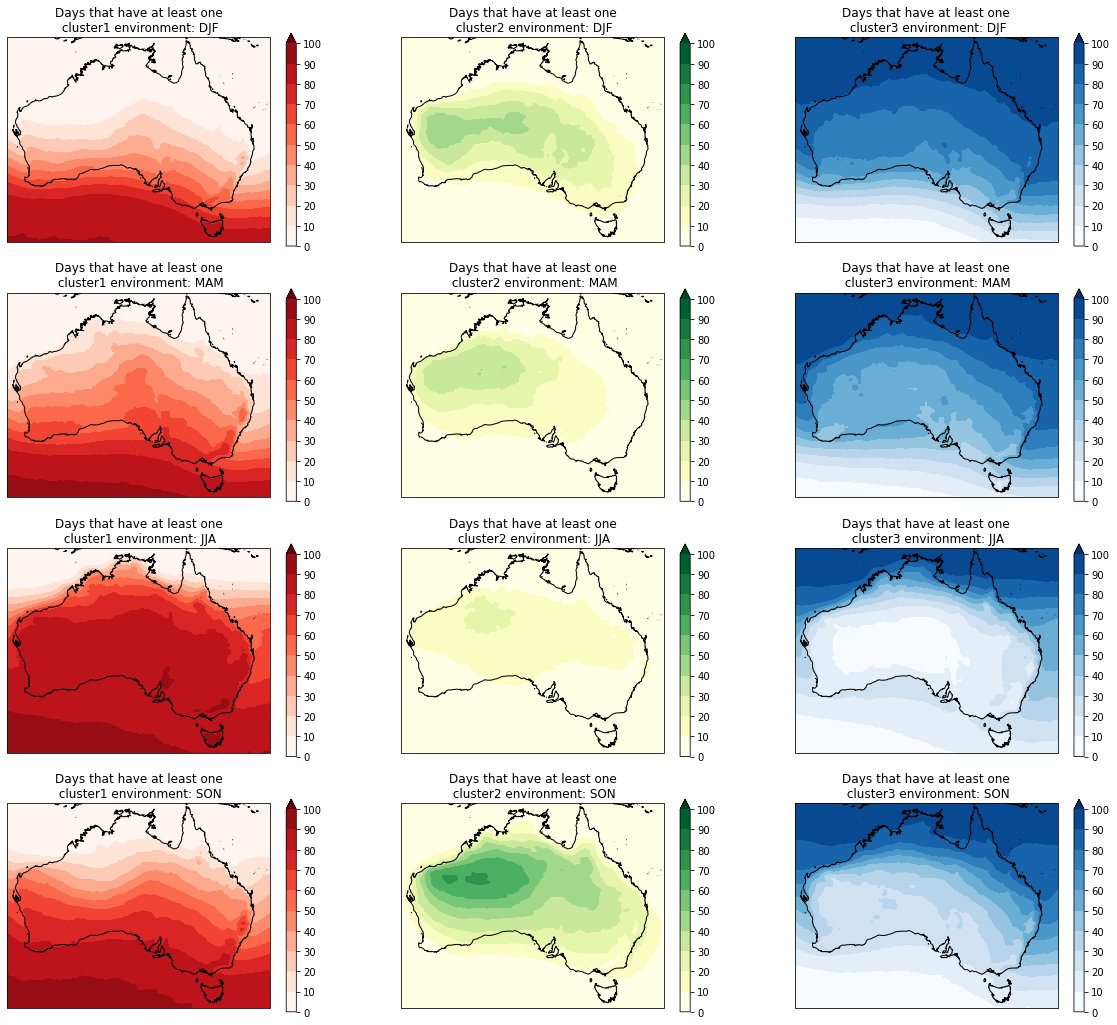

In [3]:
def plot_clim_cluster(da,times,months,ax):

    #levs = [0,1,5,10,15,20,30,40,60,90]
    levs = np.linspace(0,100,11)

    cmaps = {"cluster1":plt.get_cmap("Reds"), "cluster2":plt.get_cmap("YlGn"), "cluster3":plt.get_cmap("Blues")}

    
    c=xr.plot.contourf((da.sel({"time":np.in1d([t.month for t in times],months)}).sum("time") / (2021-1979)), 
                       cmap=cmaps[da.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Days that have at least one\n " + da.name + " environment: " + get_season(months))
    

plt.figure(figsize=[20,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1, f.cluster2, f.cluster3))
cnt=1
for season, da in iters:
    plot_clim_cluster(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .r

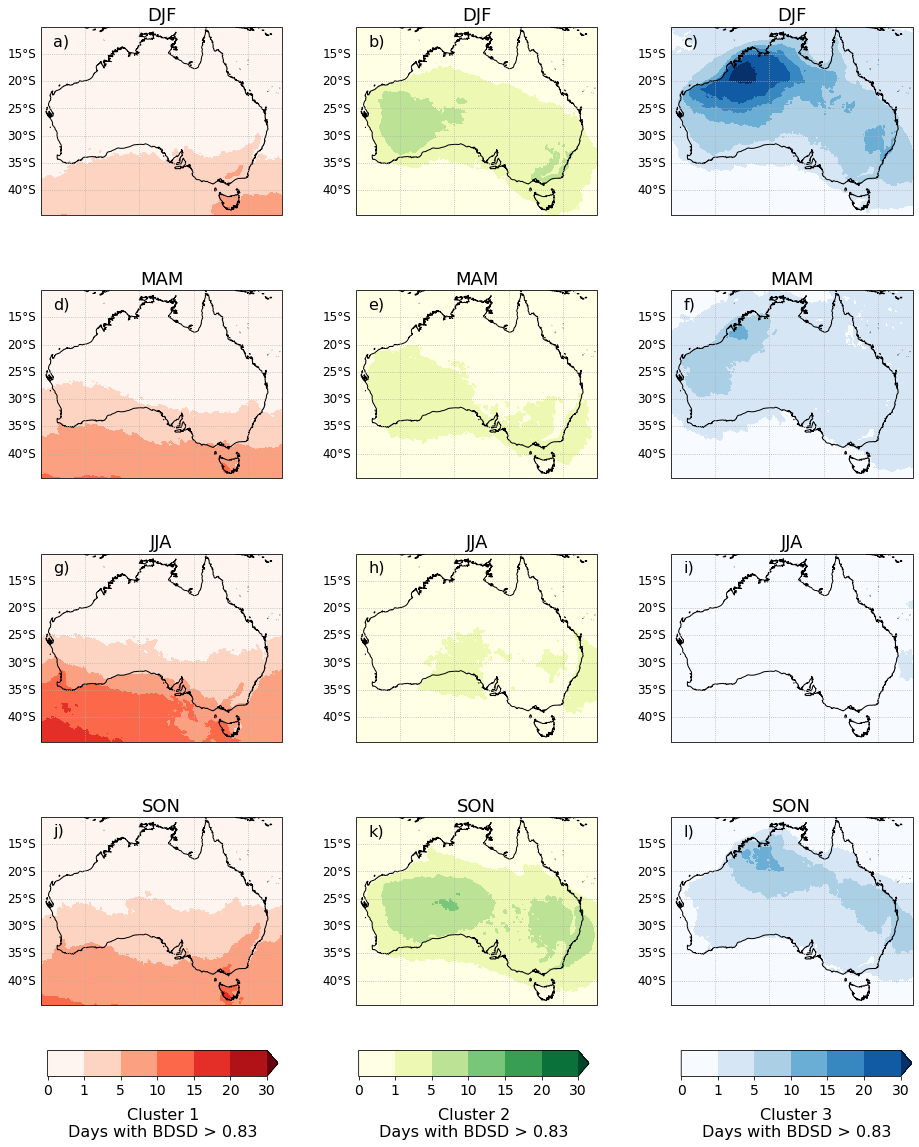

In [4]:
def plot_bdsd_cluster(da,times,months,ax,letter):

    #levs = [0,1,5,10,15,20,30,40,60,90]
    levs = [0,1,5,10,15,20,30]
    title={"cluster1_bdsd":"Cluster 1","cluster2_bdsd":"Cluster 2","cluster3_bdsd":"Cluster 3"}

    cmaps = {"cluster1_bdsd":plt.get_cmap("Reds"), "cluster2_bdsd":plt.get_cmap("YlGn"), "cluster3_bdsd":plt.get_cmap("Blues")}

    
    c=xr.plot.contourf((da.sel({"time":np.in1d([t.month for t in times],months)}).sum("time") / (2021-1979)), 
                       cmap=cmaps[da.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    plt.title(get_season(months),size=18)
    
    if get_season(months)=="SON":
        if da.name=="cluster1_bdsd":
            cax=plt.axes([0.14,0.07,0.2,0.02])
        elif da.name=="cluster2_bdsd":
            cax=plt.axes([0.41,0.07,0.2,0.02])
        elif da.name=="cluster3_bdsd":
            cax=plt.axes([0.69,0.07,0.2,0.02])
        cb=plt.colorbar(c,cax=cax,orientation="horizontal")
        cb.set_ticks(levs)
        cb.ax.tick_params(labelsize=14)
        cb.set_label(title[da.name]+"\nDays with BDSD > 0.83",size=16,labelpad=10)
    
    ax.coastlines("10m")
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.xlabels_top=False; g.ylabels_right=False
    g.xlabel_style={"size":12,'rotation':25}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER    
    
    ax.text(0.05,0.9,letter+")",size=16,transform=ax.transAxes)

plt.figure(figsize=[16,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd))
cnt=1
letters=["a","b","c","d","e","f","g","h","i","j","k","l"]
for season, da in iters:
    plot_bdsd_cluster(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()),letters[cnt-1])
    cnt=cnt+1
    
plt.subplots_adjust(hspace=0.4)
    
#plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/era5_spatial_cluster_bdsd.jpeg",bbox_inches="tight",dpi=500)

/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/eg3/ab4502/miniconda3/envs/radar/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


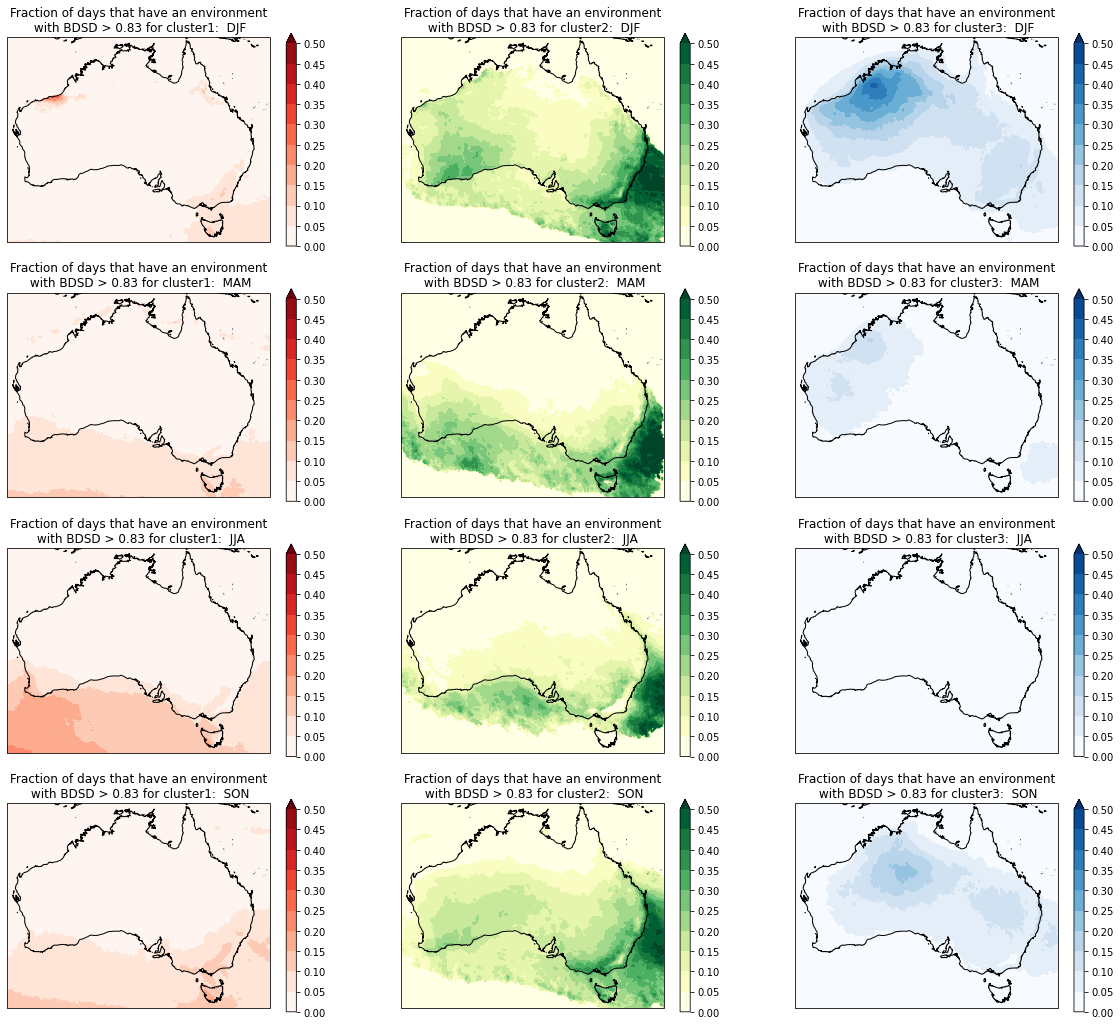

In [5]:
def plot_bdsd_fraction(da_cluster,da_bdsd,times,months,ax):

    levs = np.linspace(0,0.5,11)

    cmaps = {"cluster1":plt.get_cmap("Reds"), "cluster2":plt.get_cmap("YlGn"), "cluster3":plt.get_cmap("Blues")}

    frac = (da_bdsd.sel({"time":np.in1d([t.month for t in times],months)}).sum("time")) / \
                       (da_cluster.sel({"time":np.in1d([t.month for t in times],months)}).sum("time"))
    c=xr.plot.contourf(xr.where(
        (da_cluster.sel({"time":np.in1d([t.month for t in times],months)}).sum("time") / (2021-1979)) >= 1,
        frac, 0),
                       cmap=cmaps[da_cluster.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Fraction of days that have an environment\n with BDSD > 0.83 for " + da_cluster.name + ":  "+ get_season(months))
    

plt.figure(figsize=[20,18])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), zip((f.cluster1, f.cluster2, f.cluster3),(f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd)))
cnt=1
for season, da in iters:
    plot_bdsd_fraction(da[0], da[1], times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

In [12]:
nino=xr.Dataset(read_clim_ind("nino34",years=np.arange(1979,2021))).rename({"dim_0":"year"})
sam=xr.Dataset(read_clim_ind("sam",years=np.arange(1979,2021))).rename({"dim_0":"year"})
dmi=xr.Dataset(read_clim_ind("dmi",years=np.arange(1979,2021))).rename({"dim_0":"year"})

In [13]:
def resample_era5(months,cluster_name):

    if months==[12,1,2]:
        resampled_era5 = f.sel({"time":(np.in1d([t.month for t in times],[12,1,2])) & (times>="1979-12-1")}).coarsen({"time":3},boundary="trim").sum()[cluster_name]
        resampled_era5 = resampled_era5.assign_coords({"time":resampled_era5["time.year"]-1}).rename({"time":"year"})
    else:
        resampled_era5 = f.sel({"time":(np.in1d([t.month for t in times],months))}).coarsen({"time":3},boundary="trim").sum()[cluster_name]
        resampled_era5 = resampled_era5.assign_coords({"time":resampled_era5["time.year"]}).rename({"time":"year"})
        
    return resampled_era5
       
def sig_test(f_da,N,alpha=0.05):

    #randomly resample t2 and t1, 1,000 times, and ADD AS A DIM
    resampled = []
    np.random.seed(0)
    size1 = f_da.sel({"time":(np.in1d(f_da["time.year"],np.arange(2000,2021)))}).time.shape[0]
    size2 = f_da.sel({"time":(np.in1d(f_da["time.year"],np.arange(1979,2000)))}).time.shape[0]
    for n in np.arange(N):
        
        resampled.append(
            (f_da.isel({"time":np.random.randint(0,f_da.time.shape[0],size=size1)}).sum("time") / 21) - 
            ((f_da.isel({"time":np.random.randint(0,f_da.time.shape[0],size=size2)}).sum("time")) / 21) )

    resample_da = xr.concat(resampled,dim="resamples")
    
    actual_trend = ((f_da.sel({"time":(np.in1d(f_da["time.year"],np.arange(2000,2021)))})).sum("time") / 21) -\
                    ((f_da.sel({"time":(np.in1d(f_da["time.year"],np.arange(1979,2000)))})).sum("time") / 21)
        
    proportion_greater = (((actual_trend > (resample_da)).sum("resamples")) / N)
    proportion_less = (((actual_trend < (resample_da)).sum("resamples")) / N)    
    
    sig = xr.where( (proportion_greater >= (1-(alpha/2))) | (proportion_less >= (1-(alpha/2))), 1, 0)
    
    
    return sig

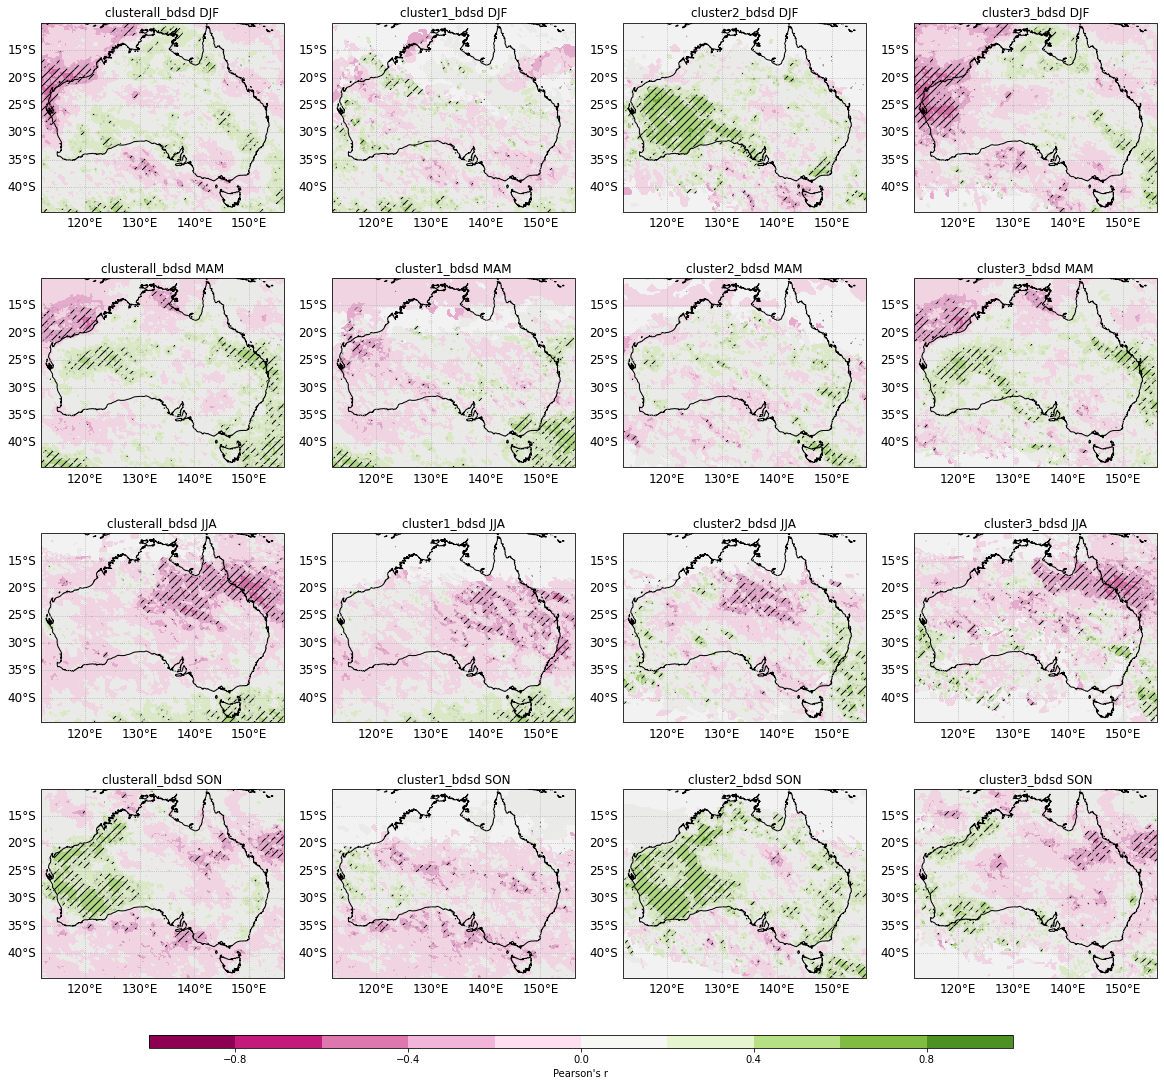

In [14]:
plt.figure(figsize=[20,18])
cnt=1
for season, sname in zip(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), ("DJF","MAM","JJA","SON")):
    for name in ["clusterall_bdsd","cluster1_bdsd","cluster2_bdsd","cluster3_bdsd"]:

        if sname=="DJF":
            end_year=2019
        else:
            end_year=2020
        
        r = xskillscore.pearson_r(
                                resample_era5(season,name).chunk({"year": -1}),
                                nino[sname].sel({"year":slice(1979,end_year)}),
                                dim="year")
        p = xskillscore.pearson_r_p_value(
                                resample_era5(season,name).chunk({"year": -1}),
                                nino[sname].sel({"year":slice(1979,end_year)}),
                                dim="year")        
        
        ax=plt.subplot(4,4,cnt,projection=ccrs.PlateCarree())        
        rplot=xr.plot.contourf(r,ax=ax,levels=np.linspace(-1,1,11),colors=list(plt.get_cmap("PiYG")(np.linspace(0,1,11))),add_colorbar=False)
        xr.plot.contourf(xr.where(p<=0.05, 1, 0), levels=[.5,1.5], colors="none", hatches=["","///"], alpha=0.05, ax=ax,add_colorbar=False)
        ax.coastlines("10m")
        ax.set_title(name+" "+sname)
        g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
        g.xlabel_style={"size":12}
        g.ylabel_style={"size":12}
        g.xformatter = LONGITUDE_FORMATTER
        g.yformatter = LATITUDE_FORMATTER    
        
        cnt=cnt+1
        
cb=plt.colorbar(rplot,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_label("Pearson's r")

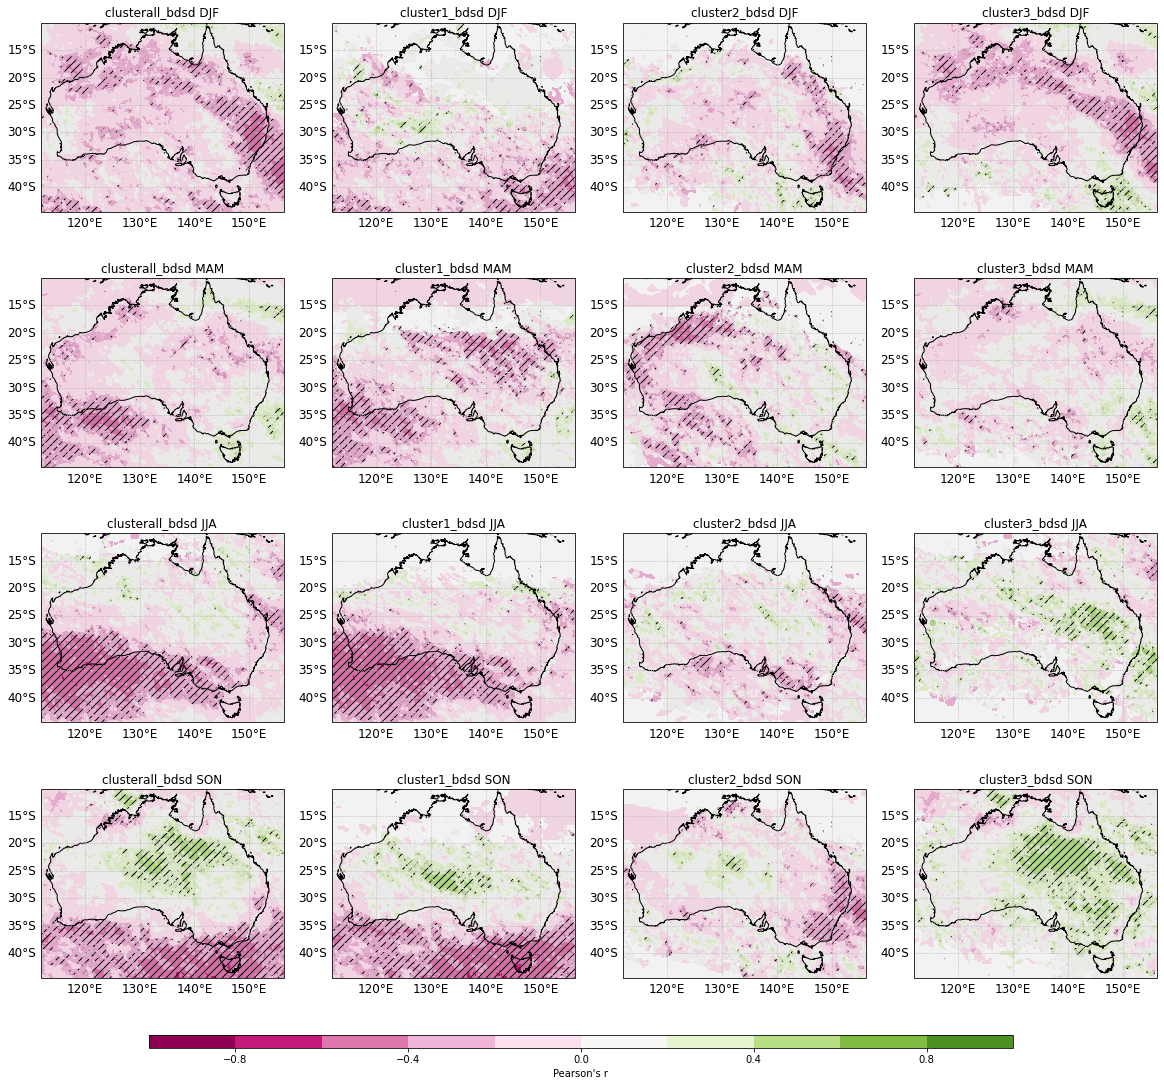

In [15]:
plt.figure(figsize=[20,18])
cnt=1
for season, sname in zip(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), ("DJF","MAM","JJA","SON")):
    for name in ["clusterall_bdsd","cluster1_bdsd","cluster2_bdsd","cluster3_bdsd"]:

        if sname=="DJF":
            end_year=2019
        else:
            end_year=2020
        
        r = xskillscore.pearson_r(
                                resample_era5(season,name).chunk({"year": -1}),
                                sam[sname].sel({"year":slice(1979,end_year)}),
                                dim="year")
        p = xskillscore.pearson_r_p_value(
                                resample_era5(season,name).chunk({"year": -1}),
                                sam[sname].sel({"year":slice(1979,end_year)}),
                                dim="year")        
        
        ax=plt.subplot(4,4,cnt,projection=ccrs.PlateCarree())        
        rplot=xr.plot.contourf(r,ax=ax,levels=np.linspace(-1,1,11),colors=list(plt.get_cmap("PiYG")(np.linspace(0,1,11))),add_colorbar=False)
        xr.plot.contourf(xr.where(p<=0.05, 1, 0), levels=[.5,1.5], colors="none", hatches=["","///"], alpha=0.05, ax=ax,add_colorbar=False)
        ax.coastlines("10m")
        ax.set_title(name+" "+sname)
        g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
        g.xlabel_style={"size":12}
        g.ylabel_style={"size":12}
        g.xformatter = LONGITUDE_FORMATTER
        g.yformatter = LATITUDE_FORMATTER         
        
        cnt=cnt+1
        
cb=plt.colorbar(rplot,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_label("Pearson's r")

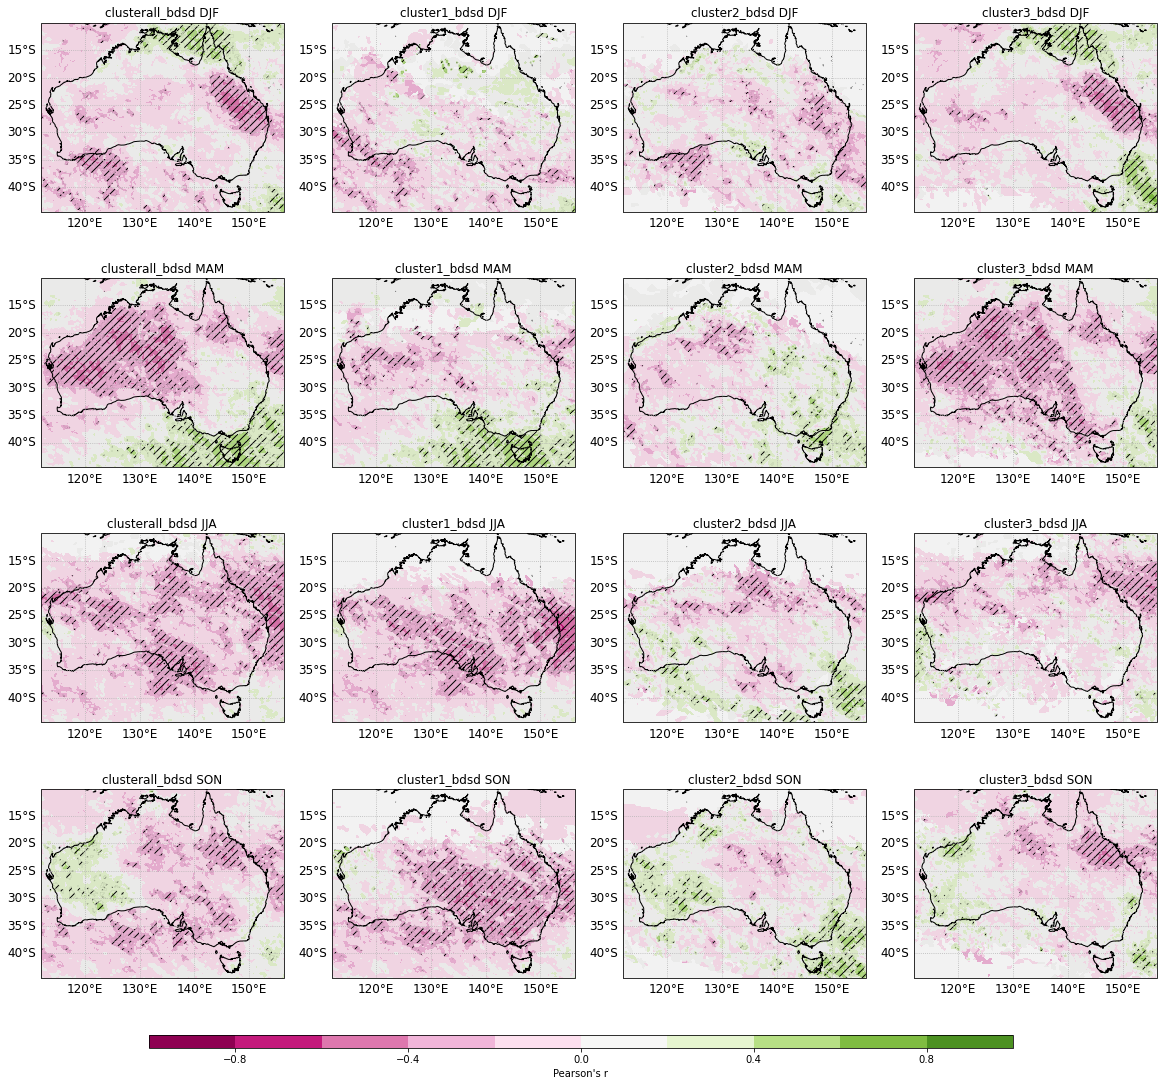

In [16]:
plt.figure(figsize=[20,18])
cnt=1
for season, sname in zip(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), ("DJF","MAM","JJA","SON")):
    for name in ["clusterall_bdsd","cluster1_bdsd","cluster2_bdsd","cluster3_bdsd"]:

        if sname=="DJF":
            end_year=2019
        else:
            end_year=2020
        
        r = xskillscore.pearson_r(
                                resample_era5(season,name).chunk({"year": -1}),
                                dmi[sname].sel({"year":slice(1979,end_year)}),
                                dim="year")
        p = xskillscore.pearson_r_p_value(
                                resample_era5(season,name).chunk({"year": -1}),
                                dmi[sname].sel({"year":slice(1979,end_year)}),
                                dim="year")        
        
        ax=plt.subplot(4,4,cnt,projection=ccrs.PlateCarree())        
        rplot=xr.plot.contourf(r,ax=ax,levels=np.linspace(-1,1,11),colors=list(plt.get_cmap("PiYG")(np.linspace(0,1,11))),add_colorbar=False)
        xr.plot.contourf(xr.where(p<=0.05, 1, 0), levels=[.5,1.5], colors="none", hatches=["","///"], alpha=0.05, ax=ax,add_colorbar=False)
        ax.coastlines("10m")
        ax.set_title(name+" "+sname)
        g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
        g.xlabel_style={"size":12}
        g.ylabel_style={"size":12}
        g.xformatter = LONGITUDE_FORMATTER
        g.yformatter = LATITUDE_FORMATTER         
        
        cnt=cnt+1
        
cb=plt.colorbar(rplot,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_label("Pearson's r")

DJF


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


MAM


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

JJA


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

SON


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

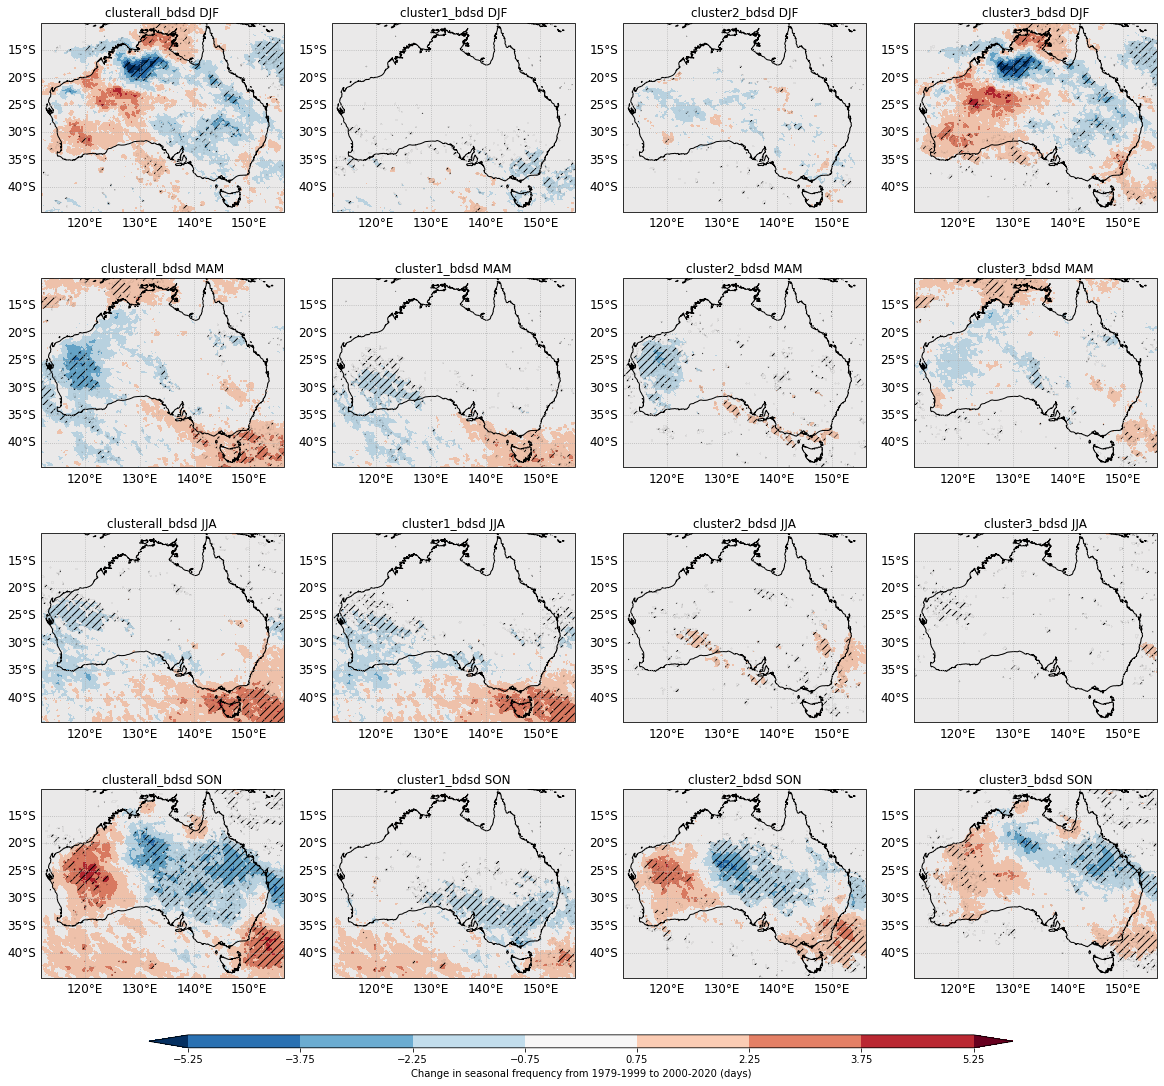

In [17]:
plt.figure(figsize=[20,18])
cnt=1
for season, sname in zip(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), ("DJF","MAM","JJA","SON")):
    print(sname)
    for name in ["clusterall_bdsd","cluster1_bdsd","cluster2_bdsd","cluster3_bdsd"]:
        
        ax=plt.subplot(4,4,cnt,projection=ccrs.PlateCarree())
        
        tplot=xr.plot.contourf(
                (f.sel({"time":(np.in1d(f["time.year"],np.arange(2000,2021))) & (np.in1d(f["time.month"], season))})[name].sum("time") / (21)) -
                (f.sel({"time":(np.in1d(f["time.year"],np.arange(1979,2000))) & (np.in1d(f["time.month"], season))})[name].sum("time") / (21)),
                        levels=np.arange(-5.25,6.75,1.5),cmap=plt.get_cmap("RdBu_r"),ax=ax,extend="both", add_colorbar=False)
        
        sig = sig_test(f.sel({"time":(np.in1d(f["time.month"], season))})[name],100)
        xr.plot.contourf(sig, levels=[.5,1.5], colors="none", hatches=["","///"], alpha=0.05, ax=ax,add_colorbar=False)

        ax.coastlines("10m")
        ax.set_title(name+" "+sname)
        g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
        g.xlabel_style={"size":12}
        g.ylabel_style={"size":12}
        g.xformatter = LONGITUDE_FORMATTER
        g.yformatter = LATITUDE_FORMATTER    
        
        cnt=cnt+1
        
cb=plt.colorbar(tplot,cax=plt.axes([0.2,0.08,0.6,0.01]),orientation="horizontal")
cb.set_label("Change in seasonal frequency from 1979-1999 to 2000-2020 (days)")